### Задача: построить предиктивную модель, которая на основании открытых данных о судах и бухгалтерской отчетности позволит спрогнозировать вероятность банкротства компании (без учета года). 

## Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [2]:
df_bankruptcies = pd.read_csv('df_bankruptcies_sample.csv')
df_accounts = pd.read_csv('df_accounts_sample.csv')

In [3]:
def information_about_df(data):
    print("Размер таблицы: ", data.shape)
    print()
    print("Название колонок:", data.columns)
    print()
    display(data.head())
    print()
    print(data.info())
    print()
    print(data.isnull().sum())
    print()
    display(data.describe())
    print()
    print("Дубликаты: ", data.duplicated().sum())
    print()
    print("Количество уникальных значений ИНН: ", len(data['inn'].unique()))

In [4]:
# смотрим данные по df df_bankruptcies
information_about_df(df_bankruptcies)

Размер таблицы:  (106, 4)

Название колонок: Index(['Unnamed: 0', 'bankrupt_id', 'bancrupt_year', 'inn'], dtype='object')



,Unnamed: 0,bankrupt_id,bancrupt_year,inn
0,0,79546,2015,5620006322
1,1,76594,2015,2111008200
2,2,94301,2016,5414100369
3,3,93799,2019,2347009476
4,4,199671,2018,7224008489



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 4 columns):
Unnamed: 0       106 non-null int64
bankrupt_id      106 non-null int64
bancrupt_year    106 non-null int64
inn              106 non-null int64
dtypes: int64(4)
memory usage: 3.4 KB
None

Unnamed: 0       0
bankrupt_id      0
bancrupt_year    0
inn              0
dtype: int64



,Unnamed: 0,bankrupt_id,bancrupt_year,inn
count,106.000000,106.000000,106.000000,1.060000e+02
mean,52.500000,183697.679245,2016.792453,5.088171e+09
std,30.743563,152405.455274,2.984777,2.166806e+09
min,0.000000,670.000000,2011.000000,1.020010e+09
25%,26.250000,70941.500000,2014.250000,3.268141e+09
50%,52.500000,117642.000000,2017.000000,5.410220e+09
75%,78.750000,284533.000000,2019.000000,6.858008e+09
max,105.000000,586227.000000,2021.000000,8.909000e+09



Дубликаты:  0

Количество уникальных значений ИНН:  106


In [5]:
# чистим данные
df_bankruptcies = df_bankruptcies.drop(['Unnamed: 0'], axis = 1)

Минимальные год:  2011
Максимальный год:  2021
Список годов:  [2015 2016 2019 2018 2017 2021 2013 2014 2012 2011 2020]

Данные по годам:
2019    21
2021    13
2015    11
2017    10
2016    10
2014    10
2020     8
2018     6
2013     6
2012     6
2011     5
Name: bancrupt_year, dtype: int64


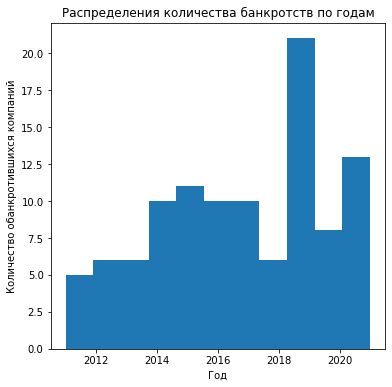

In [6]:
# анализируем колонку год
print("Минимальные год: ", df_bankruptcies.bancrupt_year.min())
print("Максимальный год: ", df_bankruptcies.bancrupt_year.max())
print("Список годов: ", df_bankruptcies.bancrupt_year.unique())
print("\nДанные по годам:")
print(df_bankruptcies.bancrupt_year.value_counts())

df_bankruptcies.bancrupt_year.plot(kind = 'hist', bins = 11, figsize = (6,6))
plt.title('Распределения количества банкротств по годам')
plt.xlabel('Год')
plt.ylabel('Количество обанкротившихся компаний')
plt.show()

In [7]:
# смотрим данные по df df_accounts
information_about_df(df_accounts)

Размер таблицы:  (1035, 7)

Название колонок: Index(['Unnamed: 0', 'inn', 'year', 'long_term_liabilities_fiscal_year',
       'short_term_liabilities_fiscal_year', 'balance_assets_fiscal_year',
       'okei'],
      dtype='object')



,Unnamed: 0,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
0,0,2465002653,2012,0.0,113756,122240,384
1,1,3505003270,2012,21461.0,20211,81132,384
2,2,3517003250,2012,0.0,0,48063,384
3,3,5501078737,2012,0.0,288763,419522,384
4,4,6140019517,2012,0.0,0,11089,384



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 7 columns):
Unnamed: 0                            1035 non-null int64
inn                                   1035 non-null int64
year                                  1035 non-null int64
long_term_liabilities_fiscal_year     960 non-null float64
short_term_liabilities_fiscal_year    1035 non-null int64
balance_assets_fiscal_year            1035 non-null int64
okei                                  1035 non-null int64
dtypes: float64(1), int64(6)
memory usage: 56.7 KB
None

Unnamed: 0                             0
inn                                    0
year                                   0
long_term_liabilities_fiscal_year     75
short_term_liabilities_fiscal_year     0
balance_assets_fiscal_year             0
okei                                   0
dtype: int64



,Unnamed: 0,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
count,1035.000000,1.035000e+03,1035.000000,9.600000e+02,1.035000e+03,1.035000e+03,1035.000000
mean,517.000000,5.024548e+09,2015.515942,1.131756e+05,1.119116e+05,2.417073e+05,383.996135
std,298.923067,2.198715e+09,2.420593,8.703670e+05,5.268918e+05,1.018560e+06,0.062077
min,0.000000,1.001004e+09,2012.000000,0.000000e+00,0.000000e+00,0.000000e+00,383.000000
25%,258.500000,3.212001e+09,2013.000000,0.000000e+00,1.376000e+03,4.054000e+03,384.000000
50%,517.000000,5.404263e+09,2015.000000,0.000000e+00,7.920000e+03,1.762900e+04,384.000000
75%,775.500000,6.907010e+09,2017.000000,1.829500e+03,5.447400e+04,9.101300e+04,384.000000
max,1034.000000,9.102060e+09,2020.000000,9.844742e+06,9.263182e+06,1.032725e+07,384.000000



Дубликаты:  0

Количество уникальных значений ИНН:  166


In [8]:
df_accounts = df_accounts.drop(['Unnamed: 0'],  axis = 1)

Минимальные год:  2012
Максимальный год:  2020
Список годов:  [2012 2013 2017 2014 2015 2016 2018 2019 2020]

Данные по годам:
2015    137
2012    135
2014    133
2013    130
2016    128
2017    120
2018    111
2019     74
2020     67
Name: year, dtype: int64


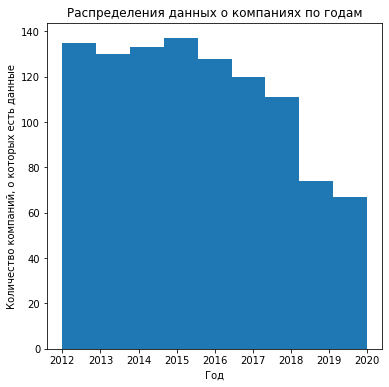

In [9]:
# анализируем колонку год
print("Минимальные год: ", df_accounts.year.min())
print("Максимальный год: ", df_accounts.year.max())
print("Список годов: ", df_accounts.year.unique())
print("\nДанные по годам:")
print(df_accounts.year.value_counts())

df_accounts.year.plot(kind = 'hist', bins = 9, figsize = (6,6))
plt.title('Распределения данных о компаниях по годам')
plt.xlabel('Год')
plt.ylabel('Количество компаний, о которых есть данные')
plt.show()

In [10]:
# анализируем колонку okei
print("Список значений: ", df_accounts.okei.unique())
print("\nДанные по значениям:")
print(df_accounts.okei.value_counts())


Список значений:  [384 383]

Данные по значениям:
384    1031
383       4
Name: okei, dtype: int64


In [11]:
new_df_accounts = df_accounts.pivot_table(index = 'inn',
                                          columns = 'year',
                                          values = ['long_term_liabilities_fiscal_year', 'short_term_liabilities_fiscal_year', 'balance_assets_fiscal_year'])
display(new_df_accounts)
print(new_df_accounts.isnull().sum())

balance_assets_fiscal_year                                          \
year                             2012      2013      2014      2015      2016   
inn                                                                             
1001003743                     4399.0    4399.0    6295.0    6051.0    4735.0   
1020010136                        NaN       NaN       NaN    3451.0   12526.0   
1203000142                        NaN       NaN       NaN       NaN       NaN   
1302000640                    32400.0   25918.0   25918.0       NaN       NaN   
1411004211                   167857.0  177828.0  166188.0  164026.0  146980.0   
...                               ...       ...       ...       ...       ...   
8617004112                        NaN       NaN    1691.0    1145.0       NaN   
8901998318                        NaN       NaN     391.0     265.0     463.0   
8908001998                    17507.0   43124.0   80361.0   71756.0   74769.0   
8909000186                    26721.0   29608.0   30838.0   21788.0       NaN   
9102060446                        NaN       NaN  107486.0  158808.0  160340.0   

                                                    \
year            2017      2018      2019      2020   
inn                                                  
1001003743    9481.0    4003.0    3930.0       NaN   
1020010136   14769.0   14589.0       NaN       NaN   
1203000142  493782.0  468357.0  523849.0  442374.0   
1302000640       NaN       NaN       NaN       NaN   
1411004211       0.0       NaN       NaN       NaN   
...              ...       ...       ...       ...   
8617004112    6230.0    8610.0       NaN       NaN   
8901998318     259.0      20.0       NaN       NaN   
8908001998   97285.0  109892.0  130731.0  128891.0   
8909000186       NaN       NaN       NaN       NaN   
9102060446  272612.0  257065.0  308868.0  273486.0   

           long_term_liabilities_fiscal_year  ...           \
year                                    2012  ...     2020   
inn                                           ...            
1001003743                               0.0  ...      NaN   
1020010136                               NaN  ...      NaN   
1203000142                               NaN  ...  52005.0   
1302000640                               0.0  ...      NaN   
1411004211                               0.0  ...      NaN   
...                                      ...  ...      ...   
8617004112                               NaN  ...      NaN   
8901998318                               NaN  ...      NaN   
8908001998                               0.0  ...      NaN   
8909000186                               0.0  ...      NaN   
9102060446                               NaN  ...   6000.0   

           short_term_liabilities_fiscal_year                             \
year                                     2012     2013     2014     2015   
inn                                                                        
1001003743                             1080.0   1080.0    296.0    260.0   
1020010136                                NaN      NaN      NaN   3900.0   
1203000142                                NaN      NaN      NaN      NaN   
1302000640                                0.0  22189.0  22189.0      NaN   
1411004211                                0.0  57566.0  56304.0  52238.0   
...                                       ...      ...      ...      ...   
8617004112                                NaN      NaN    666.0    417.0   
8901998318                                NaN      NaN    391.0    265.0   
8908001998                             7668.0  33148.0   3416.0   2992.0   
8909000186                                0.0  15445.0  20022.0  18359.0   
9102060446                                NaN      NaN  78200.0  42141.0   

                                                             
year           2016      2017      2018      2019      2020  
inn                                                          

                                    year
balance_assets_fiscal_year          2012     31
                                    2013     36
                                    2014     33
                                    2015     29
                                    2016     38
                                    2017     46
                                    2018     55
                                    2019     97
                                    2020    102
long_term_liabilities_fiscal_year   2012     31
                                    2013     36
                                    2014     33
                                    2015     29
                                    2016     38
                                    2017     46
                                    2018     55
                                    2019    133
                                    2020    138
short_term_liabilities_fiscal_year  2012     31
                                    2013     36

In [12]:
#заполним пропуски значениями -1, это буде означать, что нет данных
new_df_accounts = new_df_accounts.fillna(-1)
display(new_df_accounts)

balance_assets_fiscal_year                                          \
year                             2012      2013      2014      2015      2016   
inn                                                                             
1001003743                     4399.0    4399.0    6295.0    6051.0    4735.0   
1020010136                       -1.0      -1.0      -1.0    3451.0   12526.0   
1203000142                       -1.0      -1.0      -1.0      -1.0      -1.0   
1302000640                    32400.0   25918.0   25918.0      -1.0      -1.0   
1411004211                   167857.0  177828.0  166188.0  164026.0  146980.0   
...                               ...       ...       ...       ...       ...   
8617004112                       -1.0      -1.0    1691.0    1145.0      -1.0   
8901998318                       -1.0      -1.0     391.0     265.0     463.0   
8908001998                    17507.0   43124.0   80361.0   71756.0   74769.0   
8909000186                    26721.0   29608.0   30838.0   21788.0      -1.0   
9102060446                       -1.0      -1.0  107486.0  158808.0  160340.0   

                                                    \
year            2017      2018      2019      2020   
inn                                                  
1001003743    9481.0    4003.0    3930.0      -1.0   
1020010136   14769.0   14589.0      -1.0      -1.0   
1203000142  493782.0  468357.0  523849.0  442374.0   
1302000640      -1.0      -1.0      -1.0      -1.0   
1411004211       0.0      -1.0      -1.0      -1.0   
...              ...       ...       ...       ...   
8617004112    6230.0    8610.0      -1.0      -1.0   
8901998318     259.0      20.0      -1.0      -1.0   
8908001998   97285.0  109892.0  130731.0  128891.0   
8909000186      -1.0      -1.0      -1.0      -1.0   
9102060446  272612.0  257065.0  308868.0  273486.0   

           long_term_liabilities_fiscal_year  ...           \
year                                    2012  ...     2020   
inn                                           ...            
1001003743                               0.0  ...     -1.0   
1020010136                              -1.0  ...     -1.0   
1203000142                              -1.0  ...  52005.0   
1302000640                               0.0  ...     -1.0   
1411004211                               0.0  ...     -1.0   
...                                      ...  ...      ...   
8617004112                              -1.0  ...     -1.0   
8901998318                              -1.0  ...     -1.0   
8908001998                               0.0  ...     -1.0   
8909000186                               0.0  ...     -1.0   
9102060446                              -1.0  ...   6000.0   

           short_term_liabilities_fiscal_year                             \
year                                     2012     2013     2014     2015   
inn                                                                        
1001003743                             1080.0   1080.0    296.0    260.0   
1020010136                               -1.0     -1.0     -1.0   3900.0   
1203000142                               -1.0     -1.0     -1.0     -1.0   
1302000640                                0.0  22189.0  22189.0     -1.0   
1411004211                                0.0  57566.0  56304.0  52238.0   
...                                       ...      ...      ...      ...   
8617004112                               -1.0     -1.0    666.0    417.0   
8901998318                               -1.0     -1.0    391.0    265.0   
8908001998                             7668.0  33148.0   3416.0   2992.0   
8909000186                                0.0  15445.0  20022.0  18359.0   
9102060446                               -1.0     -1.0  78200.0  42141.0   

                                                             
year           2016      2017      2018      2019      2020  
inn                                                          

#функция по приведению суммы к одному формату

def change_money(data, check_column, list_column):
    
    for stroka in range(len(data)):
        if data.loc[stroka, check_column] == 383:
            for col in list_column:
                data.loc[stroka, col] = data.loc[stroka, col] * 1
        elif data.loc[stroka, check_column] == 384:
            for col in list_column:
                data.loc[stroka, col] = data.loc[stroka, col] * 1000
        elif data.loc[stroka, check_column] == 385:
            for col in list_column:
                data.loc[stroka, col] = data.loc[stroka, col] * 1000000

In [13]:
# объединяем таблицы

df = new_df_accounts.merge(df_bankruptcies, on=['inn'], how='left') 
print(df.shape)
display(df)

(166, 30)


,inn,"(balance_assets_fiscal_year, 2012)","(balance_assets_fiscal_year, 2013)","(balance_assets_fiscal_year, 2014)","(balance_assets_fiscal_year, 2015)","(balance_assets_fiscal_year, 2016)","(balance_assets_fiscal_year, 2017)","(balance_assets_fiscal_year, 2018)","(balance_assets_fiscal_year, 2019)","(balance_assets_fiscal_year, 2020)",...,"(short_term_liabilities_fiscal_year, 2013)","(short_term_liabilities_fiscal_year, 2014)","(short_term_liabilities_fiscal_year, 2015)","(short_term_liabilities_fiscal_year, 2016)","(short_term_liabilities_fiscal_year, 2017)","(short_term_liabilities_fiscal_year, 2018)","(short_term_liabilities_fiscal_year, 2019)","(short_term_liabilities_fiscal_year, 2020)",bankrupt_id,bancrupt_year
0,1001003743,4399.0,4399.0,6295.0,6051.0,4735.0,9481.0,4003.0,3930.0,-1.0,...,1080.0,296.0,260.0,861.0,8379.0,3881.0,4330.0,-1.0,NaN,NaN
1,1020010136,-1.0,-1.0,-1.0,3451.0,12526.0,14769.0,14589.0,-1.0,-1.0,...,-1.0,-1.0,3900.0,16187.0,36750.0,55297.0,-1.0,-1.0,176347.0,2018.0
2,1203000142,-1.0,-1.0,-1.0,-1.0,-1.0,493782.0,468357.0,523849.0,442374.0,...,-1.0,-1.0,-1.0,-1.0,165670.0,181200.0,395315.0,315556.0,380484.0,2020.0
3,1302000640,32400.0,25918.0,25918.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,22189.0,22189.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,76122.0,2015.0
4,1411004211,167857.0,177828.0,166188.0,164026.0,146980.0,0.0,-1.0,-1.0,-1.0,...,57566.0,56304.0,52238.0,42477.0,0.0,-1.0,-1.0,-1.0,154559.0,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,8617004112,-1.0,-1.0,1691.0,1145.0,-1.0,6230.0,8610.0,-1.0,-1.0,...,-1.0,666.0,417.0,-1.0,4853.0,7399.0,-1.0,-1.0,263841.0,2019.0
162,8901998318,-1.0,-1.0,391.0,265.0,463.0,259.0,20.0,-1.0,-1.0,...,-1.0,391.0,265.0,251.0,259.0,0.0,-1.0,-1.0,NaN,NaN
163,8908001998,17507.0,43124.0,80361.0,71756.0,74769.0,97285.0,109892.0,130731.0,128891.0,...,33148.0,3416.0,2992.0,4048.0,6012.0,3622.0,8636.0,14318.0,12824.0,2011.0
164,8909000186,26721.0,29608.0,30838.0,21788.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,15445.0,20022.0,18359.0,-1.0,-1.0,-1.0,-1.0,-1.0,168481.0,2017.0


In [14]:
# создаем столбец с целевым признаком 1 - банкорот, 0 - не банкрот
df['bankrupt_id'] = df['bankrupt_id'].fillna(0)
df['bancrupt_year'] = df['bancrupt_year'].fillna(0)
df['is_bankrupt'] = df['bankrupt_id'].apply(lambda x: int(x) if x==0 else 1)
df = df.drop(['bankrupt_id'], axis = 1)
display(df)

,inn,"(balance_assets_fiscal_year, 2012)","(balance_assets_fiscal_year, 2013)","(balance_assets_fiscal_year, 2014)","(balance_assets_fiscal_year, 2015)","(balance_assets_fiscal_year, 2016)","(balance_assets_fiscal_year, 2017)","(balance_assets_fiscal_year, 2018)","(balance_assets_fiscal_year, 2019)","(balance_assets_fiscal_year, 2020)",...,"(short_term_liabilities_fiscal_year, 2013)","(short_term_liabilities_fiscal_year, 2014)","(short_term_liabilities_fiscal_year, 2015)","(short_term_liabilities_fiscal_year, 2016)","(short_term_liabilities_fiscal_year, 2017)","(short_term_liabilities_fiscal_year, 2018)","(short_term_liabilities_fiscal_year, 2019)","(short_term_liabilities_fiscal_year, 2020)",bancrupt_year,is_bankrupt
0,1001003743,4399.0,4399.0,6295.0,6051.0,4735.0,9481.0,4003.0,3930.0,-1.0,...,1080.0,296.0,260.0,861.0,8379.0,3881.0,4330.0,-1.0,0.0,0
1,1020010136,-1.0,-1.0,-1.0,3451.0,12526.0,14769.0,14589.0,-1.0,-1.0,...,-1.0,-1.0,3900.0,16187.0,36750.0,55297.0,-1.0,-1.0,2018.0,1
2,1203000142,-1.0,-1.0,-1.0,-1.0,-1.0,493782.0,468357.0,523849.0,442374.0,...,-1.0,-1.0,-1.0,-1.0,165670.0,181200.0,395315.0,315556.0,2020.0,1
3,1302000640,32400.0,25918.0,25918.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,22189.0,22189.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015.0,1
4,1411004211,167857.0,177828.0,166188.0,164026.0,146980.0,0.0,-1.0,-1.0,-1.0,...,57566.0,56304.0,52238.0,42477.0,0.0,-1.0,-1.0,-1.0,2017.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,8617004112,-1.0,-1.0,1691.0,1145.0,-1.0,6230.0,8610.0,-1.0,-1.0,...,-1.0,666.0,417.0,-1.0,4853.0,7399.0,-1.0,-1.0,2019.0,1
162,8901998318,-1.0,-1.0,391.0,265.0,463.0,259.0,20.0,-1.0,-1.0,...,-1.0,391.0,265.0,251.0,259.0,0.0,-1.0,-1.0,0.0,0
163,8908001998,17507.0,43124.0,80361.0,71756.0,74769.0,97285.0,109892.0,130731.0,128891.0,...,33148.0,3416.0,2992.0,4048.0,6012.0,3622.0,8636.0,14318.0,2011.0,1
164,8909000186,26721.0,29608.0,30838.0,21788.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,15445.0,20022.0,18359.0,-1.0,-1.0,-1.0,-1.0,-1.0,2017.0,1


In [15]:
print(df.corr())
#pd.plotting.scatter_matrix(df, figsize = (12,12))
#plt.show()

                                                 inn  \
inn                                         1.000000   
(balance_assets_fiscal_year, 2012)          0.096034   
(balance_assets_fiscal_year, 2013)          0.018483   
(balance_assets_fiscal_year, 2014)         -0.019893   
(balance_assets_fiscal_year, 2015)         -0.049954   
(balance_assets_fiscal_year, 2016)         -0.078773   
(balance_assets_fiscal_year, 2017)         -0.072043   
(balance_assets_fiscal_year, 2018)         -0.046748   
(balance_assets_fiscal_year, 2019)         -0.109283   
(balance_assets_fiscal_year, 2020)         -0.105906   
(long_term_liabilities_fiscal_year, 2012)  -0.001536   
(long_term_liabilities_fiscal_year, 2013)  -0.096438   
(long_term_liabilities_fiscal_year, 2014)  -0.105493   
(long_term_liabilities_fiscal_year, 2015)  -0.104277   
(long_term_liabilities_fiscal_year, 2016)  -0.096884   
(long_term_liabilities_fiscal_year, 2017)  -0.100382   
(long_term_liabilities_fiscal_year, 2018)  -0.09

In [16]:
# требуется удалить столбец bancrupt_year, т.к. это утечка целевого признака, также возьмем данные о банкротствах за последние 6 лет  - с 2015 года
df = df.query('bancrupt_year>=2016 or bancrupt_year==0')

df_c_l = list(df.columns)
print(df_c_l)
df=df.drop([('balance_assets_fiscal_year', 2012), ('balance_assets_fiscal_year', 2013),('balance_assets_fiscal_year', 2014),
            ('long_term_liabilities_fiscal_year', 2012), ('long_term_liabilities_fiscal_year', 2013), ('long_term_liabilities_fiscal_year', 2014),
            ('short_term_liabilities_fiscal_year', 2012), ('short_term_liabilities_fiscal_year', 2013), ('short_term_liabilities_fiscal_year', 2014)],axis = 1)

['inn', ('balance_assets_fiscal_year', 2012), ('balance_assets_fiscal_year', 2013), ('balance_assets_fiscal_year', 2014), ('balance_assets_fiscal_year', 2015), ('balance_assets_fiscal_year', 2016), ('balance_assets_fiscal_year', 2017), ('balance_assets_fiscal_year', 2018), ('balance_assets_fiscal_year', 2019), ('balance_assets_fiscal_year', 2020), ('long_term_liabilities_fiscal_year', 2012), ('long_term_liabilities_fiscal_year', 2013), ('long_term_liabilities_fiscal_year', 2014), ('long_term_liabilities_fiscal_year', 2015), ('long_term_liabilities_fiscal_year', 2016), ('long_term_liabilities_fiscal_year', 2017), ('long_term_liabilities_fiscal_year', 2018), ('long_term_liabilities_fiscal_year', 2019), ('long_term_liabilities_fiscal_year', 2020), ('short_term_liabilities_fiscal_year', 2012), ('short_term_liabilities_fiscal_year', 2013), ('short_term_liabilities_fiscal_year', 2014), ('short_term_liabilities_fiscal_year', 2015), ('short_term_liabilities_fiscal_year', 2016), ('short_term_li

In [17]:
#парсим файлы .pkl

path = '/Users/Администратор/court_cases_sample/success'
csv_fname = 'res.csv'
def files_list(path, csv_fname):
    files_names_list = os.listdir(path)
    print('Всего объектов:',len(files_names_list))

    for file_name in files_names_list:
        if not os.path.isdir(file_name):
            if file_name.endswith(".pkl"):
                with open(csv_fname, 'a') as f:
                    f.writelines(file_parcing(file_name))
        else:
            continue

def file_parcing(fname):
    headers = 'inn;innRole;caseDate;caseTypecode;sum;currency;TheResult;OrigFile;CaseN;\n'    
    data_cases = []
    data_cases.append(headers)

    parced_information = pd.read_pickle(path+'/'+fname)['cases_list']
#    df = parced_information # pd.DataFrame.from_dict(predfdict)

    i = -1
    for case in parced_information:
        i +=1
        proto_line = [case['caseDate'] , case['caseType']['code'] , case['sum'],   case['currency'], case['resultType'], fname, i ]
        stringify_line = map(str, proto_line)
        proto_line =  list(stringify_line)
        
        for side in case['case_sides']:
            newline = []
            newline.append(str(side['INN']))
            newline.append(str(side['type']))
            newline.extend(proto_line)
            newline = ';'.join(newline) + '\n'
            data_cases.append(newline)

    return data_cases

files_list(path, csv_fname)

Всего объектов: 194


In [18]:
data_from_court = pd.read_csv(csv_fname, sep = ';',  encoding='windows-1251', header = 0)
display(data_from_court.head())

,inn,innRole,caseDate,caseTypecode,sum,currency,TheResult,OrigFile,CaseN,Unnamed: 9
0,1001003743,0,2020-06-26T00:00:00,6,1459183.0,643,Частично выиграно,1001003743.pkl,0,NaN
1,100100110225,0,2020-06-26T00:00:00,6,1459183.0,643,Частично выиграно,1001003743.pkl,0,NaN
2,100116145382,0,2020-06-26T00:00:00,6,1459183.0,643,Частично выиграно,1001003743.pkl,0,NaN
3,NaN,1,2020-06-26T00:00:00,6,1459183.0,643,Частично выиграно,1001003743.pkl,0,NaN
4,NaN,3,2020-06-26T00:00:00,6,1459183.0,643,Частично выиграно,1001003743.pkl,0,NaN


In [19]:
#очищаем данные
data_from_court = data_from_court.drop(['Unnamed: 9'], axis=1)
data_from_court = data_from_court.dropna()

print("Уникальные типы сторон:", data_from_court.innRole.unique())
print("Кол-во сторон с типом 3: ", len(data_from_court.query('innRole=="3"')))
print("Кол-во сторон с типом innRole: ", len(data_from_court.query('innRole=="innRole"')))
print("Уникальные типы вылюты:", data_from_court['currency'].unique())     
print("Кол-во записей с типом валюты curency: ", len(data_from_court.query('currency=="currency"')))
#display(data_from_court[data_from_court['currency']=='curency'].head())
data_from_court = data_from_court.query('currency == "643"')

data_from_court['caseDate'] = pd.to_datetime(data_from_court['caseDate'], format = '%Y-%m-%dT%H:%M:%S')
data_from_court['year']  = pd.DatetimeIndex(data_from_court['caseDate']).year
data_from_court = data_from_court.drop(['currency', 'caseDate', "OrigFile"], axis=1)

data_from_court['inn'] = data_from_court['inn'].apply(lambda x: x if x.isdigit() and ((len(x)==10) or (len(x)==12)) else None)
data_from_court = data_from_court.query('inn==inn')
data_from_court['inn'] = data_from_court['inn'].astype('int64')
data_from_court['innRole'] = data_from_court['innRole'].astype('int')
data_from_court['caseTypecode'] = data_from_court['caseTypecode'].astype('int')
data_from_court['sum'] = data_from_court['sum'].astype('float')

data_from_court = data_from_court.drop_duplicates().reset_index(drop=True)
print(data_from_court.shape)
display(data_from_court)

Уникальные типы сторон: ['0' '3' '1' 'innRole' '2']
Кол-во сторон с типом 3:  35328
Кол-во сторон с типом innRole:  771
Уникальные типы вылюты: ['643' 'currency']
Кол-во записей с типом валюты curency:  771
(35767, 7)


,inn,innRole,caseTypecode,sum,TheResult,CaseN,year
0,1001003743,0,6,1459183.0,Частично выиграно,0,2020
1,100100110225,0,6,1459183.0,Частично выиграно,0,2020
2,100116145382,0,6,1459183.0,Частично выиграно,0,2020
3,1001003630,3,6,1459183.0,Частично выиграно,0,2020
4,1001003743,0,6,79200.0,Не удалось определить,1,2014
...,...,...,...,...,...,...,...
35762,6102042177,0,1,250649610.4,Частично выиграно,1,2014
35763,9102002878,0,1,250649610.4,Частично выиграно,1,2014
35764,9102057281,0,1,250649610.4,Частично выиграно,1,2014
35765,9102202764,1,1,250649610.4,Частично выиграно,1,2014


In [20]:
data_from_court = data_from_court.query('year>=2015')
print(data_from_court.shape)
print(len(data_from_court['inn'].unique()))

(16829, 7)
5631


In [21]:
display(data_from_court.caseTypecode.value_counts())
# нам нужны данные, где caseTypecode = 5,6 (экон.правонаруш) или 1 (банкр)
data_from_court = data_from_court.query("caseTypecode == 1 or caseTypecode==5 or caseTypecode==6")
print(data_from_court.shape)
print(len(data_from_court['inn'].unique()))

6     8406
1     7105
5     1152
90     109
4       27
3       16
73      14
Name: caseTypecode, dtype: int64

(16663, 7)
5592


In [22]:
#data_from_court = data_from_court.drop(['sum', 'TheResult','CaseN', 'year'], axis = 1)

new_data_from_court = data_from_court.pivot_table(index = 'inn', columns = 'innRole',  values = 'caseTypecode', aggfunc = 'count')
new_data_from_court = new_data_from_court.fillna(0)
display(new_data_from_court)

innRole,0,1,2,3
inn,,,,
101011200,1.0,0.0,0.0,0.0
107017649,1.0,0.0,0.0,0.0
107026058,1.0,0.0,0.0,0.0
266042263,0.0,0.0,3.0,0.0
268032817,4.0,1.0,3.0,3.0
...,...,...,...,...
860805993898,0.0,0.0,0.0,1.0
861710501300,1.0,0.0,0.0,0.0
890102735807,0.0,0.0,1.0,0.0


In [23]:
new2_data_from_court = data_from_court.pivot_table(index = 'inn', columns = 'caseTypecode',  values = 'innRole', aggfunc = 'count')
new2_data_from_court = new2_data_from_court.fillna(0)
display(new2_data_from_court)

caseTypecode,1,5,6
inn,,,
101011200,1.0,0.0,0.0
107017649,1.0,0.0,0.0
107026058,1.0,0.0,0.0
266042263,3.0,0.0,0.0
268032817,11.0,0.0,0.0
...,...,...,...
860805993898,1.0,0.0,0.0
861710501300,0.0,1.0,0.0
890102735807,0.0,0.0,1.0


import pickle        

your_pickle_obj = pickle.loads(open('/Users/Администратор/court_cases_sample/success/7727656060_b.pkl', 'rb').read())
#print(your_pickle_obj)
                    


In [24]:
# объединяем таблицы
final_df = df.merge(new_data_from_court, on ="inn", how = 'left')
final_df = final_df.merge(new2_data_from_court, on ="inn", how = 'left')
final_df = final_df.fillna(0)
final_df = final_df.rename(columns={'1_x': '1', '1_y': 'case_1', '5': 'case_5', '6': 'case_6'})
final_df = final_df.drop(['inn', 'bancrupt_year'], axis = 1)
print(final_df.shape)
display(final_df.head())

(128, 26)


,"(balance_assets_fiscal_year, 2015)","(balance_assets_fiscal_year, 2016)","(balance_assets_fiscal_year, 2017)","(balance_assets_fiscal_year, 2018)","(balance_assets_fiscal_year, 2019)","(balance_assets_fiscal_year, 2020)","(long_term_liabilities_fiscal_year, 2015)","(long_term_liabilities_fiscal_year, 2016)","(long_term_liabilities_fiscal_year, 2017)","(long_term_liabilities_fiscal_year, 2018)",...,"(short_term_liabilities_fiscal_year, 2019)","(short_term_liabilities_fiscal_year, 2020)",is_bankrupt,0,1,2,3,case_1,5,6
0,6051.0,4735.0,9481.0,4003.0,3930.0,-1.0,0.0,0.0,0.0,0.0,...,4330.0,-1.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3451.0,12526.0,14769.0,14589.0,-1.0,-1.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,1,12.0,61.0,5.0,2.0,6.0,4.0,70.0
2,-1.0,-1.0,493782.0,468357.0,523849.0,442374.0,-1.0,-1.0,252652.0,213168.0,...,395315.0,315556.0,1,79.0,128.0,5.0,9.0,17.0,31.0,173.0
3,164026.0,146980.0,0.0,-1.0,-1.0,-1.0,60095.0,59514.0,0.0,-1.0,...,-1.0,-1.0,1,1.0,9.0,3.0,0.0,2.0,0.0,11.0
4,139405.0,236501.0,218592.0,352341.0,338814.0,-1.0,0.0,0.0,0.0,50000.0,...,285672.0,-1.0,1,6.0,65.0,9.0,3.0,9.0,5.0,69.0


In [25]:
print(final_df.corr())

                                            (balance_assets_fiscal_year, 2015)  \
(balance_assets_fiscal_year, 2015)                                    1.000000   
(balance_assets_fiscal_year, 2016)                                    0.989292   
(balance_assets_fiscal_year, 2017)                                    0.987061   
(balance_assets_fiscal_year, 2018)                                    0.950946   
(balance_assets_fiscal_year, 2019)                                    0.870252   
(balance_assets_fiscal_year, 2020)                                    0.867526   
(long_term_liabilities_fiscal_year, 2015)                             0.901413   
(long_term_liabilities_fiscal_year, 2016)                             0.938362   
(long_term_liabilities_fiscal_year, 2017)                             0.918656   
(long_term_liabilities_fiscal_year, 2018)                             0.884972   
(long_term_liabilities_fiscal_year, 2019)                             0.875190   
(long_term_liabi

### Вывод:
Таблица df_bankruptcies содержит список компаний, претерпевших банкротство и имеет размер 106 на 4 ('Unnamed: 0', 'bankrupt_id', 'bancrupt_year', 'inn'). Пропущеных значений нет, типы данных в порядке, уникальных значений ИНН 106, что соответствует строкам таблицы. Я удалила колонку 'Unnamed: 0', которая не несет в себе информациооной нагрузке и в которой значения соответствуют индексам. В таблице указаны данные за период 2011 - 2021 гг. Больше всех обанкротившихся компаний было в 2019 году - 21 компания.
Таблица df_accounts собержит информацию об активах и задолженности компаний за разные года и имеер размер 1035 на 7 ('Unnamed: 0', 'inn', 'year', 'long_term_liabilities_fiscal_year', 'short_term_liabilities_fiscal_year', 'balance_assets_fiscal_year', 'okei'). Пропущенные значения есть только в колонке long_term_liabilities_fiscal_year (75 шт, что менее 1% данных). Также тип данных по колонке long_term_liabilities_fiscal_year я изменила с float на int для лучшего визуального восприятия и удобства подсчета. Количество уникальных значений ИНН 166, что означает, что по одной компаниии могут быть разные данные зп разные года. Я удалила колонку 'Unnamed: 0', которая не несет в себе информациооной нагрузке и в которой значения соответствуют индексам. В таблице указаны данные за период 2012 - 2020 гг. За прошлые годы данных о компаниях больше чем за последниие два (2019, 2020). Финансовые данные в основном представлены в тысяцах рублей (код). Переводить значения не буду, т.к. фин. показатели даны в относительных величинах. После анализа я сгруппировала данные так, чтобы у нас стало 166 строк (уникальные ИНН), а в столбцах отразилась финансовая информация по годам.
Далее я сгруппировала финансовые данные и банные об обанкротившихся компаниях в одну таблицу final_df. Выделила целевой признак is_buncrupt: 1 - банкорот, 0 - не банкрот. Удалила данные раньше 2015 года, чтобы не перегружать таблицу признаками. Я также спарсила данные с судебных файлов, где выделила inn, innRole, caseTypecode,	sum,	TheResult,	CaseN,	year. Проанализировав данные я оставила следующую информацию: ИНН, роль {0:'истец', 1:'ответчик', 2:'свидетель', 3} и тип дела (1 - дела о банкротствах, 5 и 6 - экономические споры). Эти данные я внесла в общую таблицу final_df. 

## Анализ моделей, подбор гиперпараметров

In [26]:
# проверяем на сбалансированность классов

print(final_df.is_bankrupt.value_counts())

1    68
0    60
Name: is_bankrupt, dtype: int64


In [27]:
# выделяем целевой признак, разбиваем данные на выборки

def features_target(data):
    features = data.drop(['is_bankrupt'], axis = 1)
    target = data['is_bankrupt']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.4, random_state = 123)
    features_valid, features_test, target_valid, target_test= train_test_split(features_valid, target_valid, test_size = 0.5, random_state=123)
    return features_train, features_valid, features_test, target_train, target_valid, target_test

# нормированные данные
def features_target_std(data):
    features = data.drop(['is_bankrupt'], axis = 1)
    target = data['is_bankrupt']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.4, random_state = 123)
    features_valid, features_test, target_valid, target_test= train_test_split(features_valid, target_valid, test_size = 0.5, random_state=123)
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train_scaler = scaler.transform(features_train)
    features_valid_scaler = scaler.transform(features_valid)
    features_test_scaler = scaler.transform(features_test)
    return features_train_scaler, features_valid_scaler,features_test_scaler, target_train, target_valid, target_test

features_train_std, features_valid_std,features_test_std, target_train_std, target_valid_std, target_test_std = features_target_std(final_df)

features_train, features_valid, features_test, target_train, target_valid, target_test = features_target(final_df)

In [28]:
#проверим адекватность на примере DummyClassifier
model = DummyClassifier(strategy="most_frequent", random_state=123)
model.fit(features_train, target_train)
predicted = model.predict(features_valid)

print("точность DummyClassifier", model.score(features_valid, target_valid))
print("f1 DummyClassifier", f1_score(target_valid, predicted))
print("roc-auc DummyClassifier", roc_auc_score(target_valid, predicted))

точность DummyClassifier 0.4230769230769231
f1 DummyClassifier 0.5945945945945945
roc-auc DummyClassifier 0.5


In [29]:
# LogisticRegression 
model = LogisticRegression(solver = 'liblinear', random_state = 123)
model.fit(features_train, target_train)
predicted = model.predict(features_valid)

print("точность LogisticRegression", model.score(features_valid, target_valid))
print("f1 LogisticRegression", f1_score(target_valid, predicted))
print("roc-auc LogisticRegression", roc_auc_score(target_valid, predicted))
print()
# LogisticRegression 
model = LogisticRegression(solver = 'liblinear', random_state = 123)
model.fit(features_train_std, target_train_std)
predicted = model.predict(features_valid_std)

print("точность LogisticRegression при нормированных признаках", model.score(features_valid_std, target_valid_std))
print("f1 LogisticRegression при нормированных признаках", f1_score(target_valid_std, predicted))
print("roc-auc LogisticRegression при нормированных признаках", roc_auc_score(target_valid_std, predicted))

точность LogisticRegression 0.5
f1 LogisticRegression 0.43478260869565216
roc-auc LogisticRegression 0.49393939393939396

точность LogisticRegression при нормированных признаках 0.8461538461538461
f1 LogisticRegression при нормированных признаках 0.7999999999999999
roc-auc LogisticRegression при нормированных признаках 0.8303030303030303


In [30]:
# RandomForestClassifier
model = RandomForestClassifier(random_state = 123, max_depth=2, n_estimators = 8)
model.fit(features_train, target_train)
predicted = model.predict(features_valid)

print("точность RandomForestClassifier", model.score(features_valid, target_valid))
print("f1 RandomForestClassifier", f1_score(target_valid, predicted))
print("roc-auc RandomForestClassifier", roc_auc_score(target_valid, predicted))

точность RandomForestClassifier 0.9230769230769231
f1 RandomForestClassifier 0.9166666666666666
roc-auc RandomForestClassifier 0.9333333333333333


#код для подбора параметров RandomForestClassifier

n_estimatots = 0
max_depth = 0
best_score = 0
for depth in range(2,31,3):
    for n in range(2,60,3):
        model = RandomForestClassifier(random_state = 123, max_depth=depth, n_estimators = n)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted)
        if best_score<f1:
            best_score=f1
            max_depth = depth
            n_estimators = n

model = RandomForestClassifier(n_estimators=n_estimators, max_depth = max_depth, random_state = 123)
model.fit(features_train, target_train)
predicted = model.predict(features_valid)
f1 = f1_score(target_valid, predicted)
print("Результаты модели RandomForestClassifier")
print("f1:", f1)
print("Лучшая глубина:", max_depth, "   |   Лучшее кол-во деревьев:", n_estimators)

In [31]:
#SVC
from sklearn import svm
model = svm.SVC(kernel='linear')
model.fit(features_train_std, target_train_std)
accuracy = model.score(features_valid_std, target_valid_std)
print("точность SVC при нормированных признаках", accuracy)
print("f1 SVC при нормированных признаках", f1_score(target_valid_std, predicted))
print("roc-auc SVC при нормированных признаках", roc_auc_score(target_valid_std, predicted))

точность SVC при нормированных признаках 0.8461538461538461
f1 SVC при нормированных признаках 0.9166666666666666
roc-auc SVC при нормированных признаках 0.9333333333333333


In [32]:
# переименовываем колонки для LGB

features_train_lgb, features_valid_lgb, features_test_lgb, target_train_lgb, target_valid_lgb, target_test_lgb = features_target(final_df)

final_col = list(features_train_lgb.columns)
i = 0
for col in final_col:
    i +=1
    features_train_lgb= features_train_lgb.rename(columns = {col:str(i)+'a'})
    features_valid_lgb = features_valid_lgb.rename(columns = {col:str(i)+'a'})
    features_test_lgb = features_test_lgb.rename(columns = {col:str(i)+'a'})

In [33]:
# LGBMClassifier
model = LGBMClassifier(max_depth=2, n_estimators =2, random_state = 123)
model.fit(features_train_lgb, target_train_lgb)
predicted = model.predict(features_valid_lgb)
print("точность LGBMClassifier", model.score(features_valid_lgb, target_valid_lgb))
print("f1 LGBMClassifier", f1_score(target_valid_lgb, predicted))
print("roc-auc LGBMClassifier", roc_auc_score(target_valid_lgb, predicted))

точность LGBMClassifier 0.9230769230769231
f1 LGBMClassifier 0.9166666666666666
roc-auc LGBMClassifier 0.9333333333333333


#код для подбора параметров LGBMClassifier 
itera = 0
max_depth = 0
best_score = 0
for depth in range(2,31,1):
    for n in range(2,60,3):
        model = LGBMClassifier(n_estimators =n, max_depth = depth, random_state = 123)
        model.fit(features_train_lgb, target_train_lgb)
        predicted = model.predict(features_valid_lgb)
        f1 = f1_score(target_valid_lgb, predicted)
        if best_score<f1:
            best_score=f1
            max_depth = depth
            itera = n

model = LGBMClassifier(n_estimators =itera, max_depth = max_depth, random_state = 123)
model.fit(features_train_lgb, target_train_lgb)
predicted = model.predict(features_valid_lgb)
f1 = f1_score(target_valid_lgb, predicted)
print("Результаты модели LGBMClassifier")
print("f1:", f1)
print("Лучшая глубина:", max_depth, "   |   Лучшее кол-во деревьев:", itera)

### Вывод
Сперва я проверила целевой признак на сбалансированность классов: 1 - 68, 0 - 60. Классы сбалансированны. Данные я разделила на три выболрки обучающая, валидационная и тестовая в пропорции 3:1:1. 
Модели показали следующие результаты:
точность DummyClassifier 0.42
f1 DummyClassifier 0.59
roc-auc DummyClassifier 0.5

точность LogisticRegression 0.5
f1 LogisticRegression 0.43
roc-auc LogisticRegression 0.49

точность LogisticRegression при нормированных признаках 0.84
f1 LogisticRegression при нормированных признаках 0.79
roc-auc LogisticRegression при нормированных признаках 0.83

точность SVC при нормированных признаках 0.84
f1 SVC при нормированных признаках 0.91
roc-auc SVC при нормированных признаках 0.93

точность LGBMClassifier 0.92
f1 LGBMClassifier 0.91
roc-auc LGBMClassifier 0.93

точность RandomForestClassifier 0.92
f1 RandomForestClassifier 0.91
roc-auc RandomForestClassifier 0.93

лучшие результаты на валидационных данных показали модели RandomForestClassifier с параметрами (max_depth=2, n_estimators = 8) и LGBMClassifier с параметрами (max_depth=2, n_estimators =2). Проверим как работают модели на тестовых данных.

## Проверка модели на тестовых данных

In [34]:
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train,target_valid])

features_train_lgb = pd.concat([features_train_lgb, features_valid_lgb])
target_train_lgb = pd.concat([target_train_lgb,target_valid_lgb])

In [35]:
# LGBMClassifier
model = LGBMClassifier(max_depth=2, n_estimators =2, random_state = 123)
model.fit(features_train_lgb, target_train_lgb)
predicted = model.predict(features_test_lgb)
print("точность LGBMClassifier", model.score(features_test_lgb, target_test_lgb))
print("полнота LGBMClassifier", recall_score(target_test_lgb, predicted))
print("f1 LGBMClassifier", f1_score(target_test_lgb, predicted))
print("roc-auc LGBMClassifier", roc_auc_score(target_test_lgb, predicted))


точность LGBMClassifier 0.9230769230769231
полнота LGBMClassifier 0.9333333333333333
f1 LGBMClassifier 0.9333333333333333
roc-auc LGBMClassifier 0.9212121212121213


In [36]:
# RandomForestClassifier
model = RandomForestClassifier(random_state = 123, max_depth=2, n_estimators = 8)
model.fit(features_train, target_train)
predicted = model.predict(features_test)

print("точность RandomForestClassifier", model.score(features_test, target_test))
print("полнота RandomForestClassifier", recall_score(target_test, predicted))
print("f1 RandomForestClassifier", f1_score(target_test, predicted))
print("roc-auc RandomForestClassifier", roc_auc_score(target_test, predicted))

# определяем важность признаков модели
importances = model.feature_importances_
feature_list = list(features_train.columns)
features_results = pd.DataFrame({'feature':feature_list, 'importance': importances})
print()
print("Важность признаков:")
display(features_results.sort_values(by = 'importance', ascending = False))

точность RandomForestClassifier 0.9230769230769231
полнота RandomForestClassifier 1.0
f1 RandomForestClassifier 0.9375
roc-auc RandomForestClassifier 0.9090909090909091

Важность признаков:


,feature,importance
22,case_1,0.370099
24,6,0.290280
19,1,0.129070
20,2,0.055032
17,"(short_term_liabilities_fiscal_year, 2020)",0.028972
18,0,0.028756
7,"(long_term_liabilities_fiscal_year, 2016)",0.028019
15,"(short_term_liabilities_fiscal_year, 2018)",0.025008
13,"(short_term_liabilities_fiscal_year, 2016)",0.019697
4,"(balance_assets_fiscal_year, 2019)",0.007272


### Вывод
точность LGBMClassifier 0.92
полнота LGBMClassifier 0.93
f1 LGBMClassifier 0.93
roc-auc LGBMClassifier 0.92

точность RandomForestClassifier 0.92
полнота RandomForestClassifier 1.0
f1 RandomForestClassifier 0.94
roc-auc RandomForestClassifier 0.91

Результаты моделей LGBMClassifier и RandomForestClassifier примерно одинаковы, но в продакшн я бы рекомендовала модель RandomForestClassifier с параметрами (max_depth=2, n_estimators = 8), т.к. она выявила всех банкротов (метрика полнота = 1). Также наиболее важными признаками в обучении модели являются case_1	(0.37) - судебное дело о бакротстве; 6	(0.29) - судебное дело об экономических спорах;	1 (0.129) - компания является ответчиком. Таких образом данные о судебных делах оказались наиболее важными. Но стоит отметить, что в нашем случае финансовые данные были не полными.

### исполняемый код, который можно будет запустить на проде: на вход подаются файлы аналогичного формата (по одному), модель должна возвращать прогнозное значение.

In [37]:
def prod_load():
    financial_file = input('Enter a financial file name: ')  #df_accounts_sample.csv
    financial_df = pd.read_csv(financial_file)               #court_cases_sample/success

    financial_df = financial_df.drop(['Unnamed: 0'],  axis = 1)
    financial_df = financial_df.query('year>2014')
    new_financial_df = financial_df.pivot_table(index = 'inn',
                                              columns = 'year',
                                              values = ['long_term_liabilities_fiscal_year', 'short_term_liabilities_fiscal_year', 'balance_assets_fiscal_year']).reset_index()
    new_financial_df = new_financial_df.fillna(-1)


    directory = input('Enter directory in /Users/Администратор/: ')
    path = '/Users/Администратор/' + directory
    csv_fname = 'res.csv'
    files_list(path, csv_fname)
    court_data = pd.read_csv(csv_fname, sep = ';',  encoding='windows-1251', header = 0)
    court_data = court_data.drop(['Unnamed: 9'], axis=1)
    court_data = court_data.dropna()
    court_data = court_data.query('currency == "643"')
    court_data['year']  = pd.DatetimeIndex(court_data['caseDate']).year
    court_data = court_data.drop(['currency', 'caseDate', "OrigFile", 'caseDate', 'sum'], axis=1)
    court_data['inn'] = court_data['inn'].apply(lambda x: x if x.isdigit() and ((len(x)==10) or (len(x)==12)) else None)
    court_data = court_data.query('inn==inn')
    court_data['inn'] = court_data['inn'].astype('int64')
    court_data['innRole'] = court_data['innRole'].astype('int')
    court_data['caseTypecode'] = court_data['caseTypecode'].astype('int')
    court_data = court_data.drop_duplicates().reset_index(drop=True)
    court_data = court_data.query('year>=2015')
    court_data = court_data.query("caseTypecode == 1 or caseTypecode==5 or caseTypecode==6")
    court_data = court_data.drop(['TheResult', 'CaseN', 'year'], axis=1)

    new_court_data = court_data.pivot_table(index = 'inn', columns = 'innRole',  values = 'caseTypecode', aggfunc = 'count')
    new_court_data = new_court_data.fillna(0)
    new2_court_data = court_data.pivot_table(index = 'inn', columns = 'caseTypecode',  values = 'innRole', aggfunc = 'count')
    new2_court_data = new2_court_data.fillna(0)

    f_df = new_financial_df.merge(new_court_data, on ="inn", how = 'left')
    f_df = f_df.merge(new2_court_data, on ="inn", how = 'left')
    f_df = f_df.fillna(0)

    f_df = f_df.rename(columns={'1_x': '1', '1_y': 'case_1', '5': 'case_5', '6': 'case_6'})
    inn = f_df['inn']
    f_df = f_df.drop(['inn', ('inn', '') ], axis = 1)


    #ML
    features = final_df.drop(['is_bankrupt'], axis = 1)
    target = final_df['is_bankrupt']

    model = RandomForestClassifier(random_state = 123, max_depth=2, n_estimators = 8)
    model.fit(features_train, target_train)
    predicted = model.predict(f_df)

    result = pd.DataFrame(predicted)
    result['inn'] = inn
    result['inn'] = result['inn'].astype('str')
    result.to_excel("predicted.xls", index=False)
    print('done')

In [38]:
prod_load()

Enter a financial file name: df_accounts_sample.csv
Enter directory in /Users/Администратор/: court_cases_sample/success
Всего объектов: 194
done
